### Real Estate Price Prediction Project
The goal is to predict the price of a house in Banglore based on the following parameters: 
- **Location**
- **Number of bedrooms**
- **Total square feet**
- **Number of bathrooms**

Downloaded the initial data from [here](Bengaluru_House_Data) on Kaggle

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit

In [2]:
import warnings
warnings.filterwarnings("ignore")

- **Importing the initial dataset**

In [3]:
house = pd.read_csv("data\\Bengaluru_House_Data.csv")
house.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
house.shape

(13320, 9)

- **We'll mostly focus on the location, size, total_sqft, bath and price columns**

In [5]:
house.drop(["area_type", "availability", "society", "balcony"], axis=1, inplace=True)

In [6]:
house.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

### Removing the missing values
- since we have 13320 rows, we can safely remove the 73 rows where the number of bath is missing

In [7]:
house.dropna(inplace=True)

### Cleanign the size column
- In order to be able to work with the data, the size column needs to have int values. Here's how we can clean this column: 

In [8]:
house["size"] = house["size"].map(lambda x: int(x.split()[0]))
house.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056,2.0,39.07
1,Chikka Tirupathi,4,2600,5.0,120.00
2,Uttarahalli,3,1440,2.0,62.00
3,Lingadheeranahalli,3,1521,3.0,95.00
4,Kothanur,2,1200,2.0,51.00


### Cleaning the total_sqft column
- The following function and next dataset show cases where the total_sqft column doesn't not standard value. This needs to be cleaned. 

In [9]:
def is_float(x):
    try:
        float(x)
    except: 
        return False 
    return True

In [10]:
house[~house.total_sqft.apply(is_float)]

,location,size,total_sqft,bath,price
30,Yelahanka,4,2100 - 2850,4.0,186.000
122,Hebbal,4,3067 - 8156,4.0,477.000
137,8th Phase JP Nagar,2,1042 - 1105,2.0,54.005
165,Sarjapur,2,1145 - 1340,2.0,43.490
188,KR Puram,2,1015 - 1540,2.0,56.800
...,...,...,...,...,...
12975,Whitefield,2,850 - 1060,2.0,38.190
12990,Talaghattapura,3,1804 - 2273,3.0,122.000
13059,Harlur,2,1200 - 1470,2.0,72.760
13265,Hoodi,2,1133 - 1384,2.0,59.135


- The following function returns the average value for cases like 2100 - 2850,
- removes the cases like 34.46Sq. Meter or 4125Perch,
- and returns the float values of the rest

In [11]:
def convert_size(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [12]:
house["total_sqft"] = house["total_sqft"].map(lambda x: convert_size(x))

### Exploring the location column
- It's a categorical feature and if we keep all the locations, we'll have hundreds of features upon hot encoding. 
- There are 1304 unique locations. We'll categorize locations that are repeated less than 10 times as other

In [13]:
len(house["location"].unique())

1304

In [14]:
loc_stats = house["location"].value_counts()
loc_stats_less_than_10 = loc_stats[loc_stats<=10]

In [15]:
house["location"] = house["location"].map(lambda x: "other" if x in loc_stats_less_than_10 else x)

- Now we have only 242 unique locations in the dataset

In [16]:
# Now we have only 242 unique locations in the dataset
len(house["location"].unique())

242

### Outlier removal
**Total sqft per number of bedrooms**
- We'll define a threshold for room size. We'll assume a typical sqft per room is around 300
- Below we can see cases where the total size is not aligned with the total number of bedrooms

In [17]:
house[house.total_sqft/house["size"]<300].head()

,location,size,total_sqft,bath,price
9,other,6,1020.0,6.0,370.0
45,HSR Layout,8,600.0,9.0,200.0
58,Murugeshpalya,6,1407.0,4.0,150.0
68,other,8,1350.0,7.0,85.0
70,other,3,500.0,3.0,100.0


- Here we remove those unusual values

In [18]:
house_no_outlier = house[~(house.total_sqft/house["size"]<300)]
house_no_outlier.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2,1056.0,2.0,39.07
1,Chikka Tirupathi,4,2600.0,5.0,120.00
2,Uttarahalli,3,1440.0,2.0,62.00
3,Lingadheeranahalli,3,1521.0,3.0,95.00
4,Kothanur,2,1200.0,2.0,51.00


**It's also worth calculating the price per sqft and explore the values**
- Assuming our dataset has a normal distribution, 68 % of the data fall within the mean and 1 standard deviation. We'll remove all values that are not in that range. **We do this per location because some locations might have a high price and some lower prices.**

In [19]:
house_no_outlier["price_per_sqrt"] = house_no_outlier["price"]*100000/house_no_outlier["total_sqft"]
house_no_outlier.head()

,location,size,total_sqft,bath,price,price_per_sqrt
0,Electronic City Phase II,2,1056.0,2.0,39.07,3699.810606
1,Chikka Tirupathi,4,2600.0,5.0,120.00,4615.384615
2,Uttarahalli,3,1440.0,2.0,62.00,4305.555556
3,Lingadheeranahalli,3,1521.0,3.0,95.00,6245.890861
4,Kothanur,2,1200.0,2.0,51.00,4250.000000


- We can see extreme values such as the min (267 Rupees) and max (176470 Rupees) are very unusual

In [20]:
house_no_outlier.price_per_sqrt.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqrt, dtype: float64

In [21]:
house_no_outlier.shape

(12502, 6)

- the following code removes around 2000 outliers from the pps column

In [22]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location"):
        m = np.mean(subdf.price_per_sqrt)
        st = np.std(subdf.price_per_sqrt)
        reduced_df = subdf[(subdf.price_per_sqrt > (m - st)) & (subdf.price_per_sqrt <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [23]:
house_no_outlier = remove_pps_outliers(house_no_outlier)
house_no_outlier.shape

(10244, 6)

- **Comparing the price for houses with the same sqft but different number of bedrooms**
- The following visualization shows some houses of the same size and location with 2 bedrooms which are more expensive than those of 3 bedrooms; and this does not make any sense. We'd like to remove these anomalies 

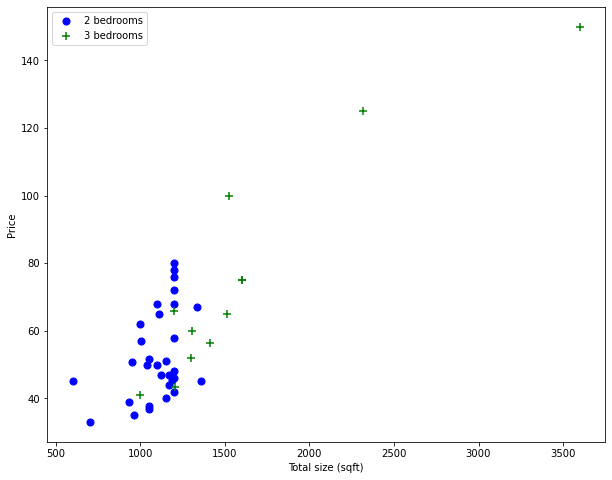

In [24]:
def plot_scatter(df, loc):
    df_3 = df[(df.location == loc) & (df["size"] == 3)]
    df_2 = df[(df.location == loc) & (df["size"] == 2)]
    fig, ax = plt.subplots(figsize = (10, 8))
    
    plt.scatter(df_2.total_sqft, df_2.price, color = "blue", label = "2 bedrooms", s = 50)
    plt.scatter(df_3.total_sqft, df_3.price, color = "green", label = "3 bedrooms", s = 50, marker = "+")
    
    plt.xlabel("Total size (sqft)")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
plot_scatter(house_no_outlier, "Ramamurthy Nagar")

- We'll groupby location and then the number of bedrooms, and then remove rows where the price is less than the average price of the houses with one bedroom less! Here is the following code to remove the outliers related to price and the number of bedrooms:

In [25]:
def remove_bedroom_outliers(df):
    exclude_indices = np.array([])
    for location, loc_subdf in df.groupby("location"):
        stats_bedrooms = {}
        for bedrooms, bed_subdf in loc_subdf.groupby("size"):
            stats_bedrooms[bedrooms] = {
                "mean": np.mean(bed_subdf.price_per_sqrt), 
                "std": np.std(bed_subdf.price_per_sqrt),
                "count": bed_subdf.shape[0]
            }
        for bedrooms, bed_subdf in loc_subdf.groupby("size"):
            stats = stats_bedrooms.get(bedrooms - 1)
            if stats and stats["count"] > 5:
                exclude_indices = np.append(exclude_indices, bed_subdf[bed_subdf.price_per_sqrt < (stats["mean"])].index.values)
    return df.drop(exclude_indices, axis = "index")

- **We can see the above algorithm removed around 3000 outliers associated with the price and the number of bedrooms**

In [26]:
house_no_outlier.shape

(10244, 6)

In [27]:
house_no_outlier = remove_bedroom_outliers(house_no_outlier)
house_no_outlier.shape

(7342, 6)

- Now, let's use the plot_scatter() function and plot the same diagram and see if there's been any changes
- We can see lots of green dots that were initially below the blue dots are gone removed. 

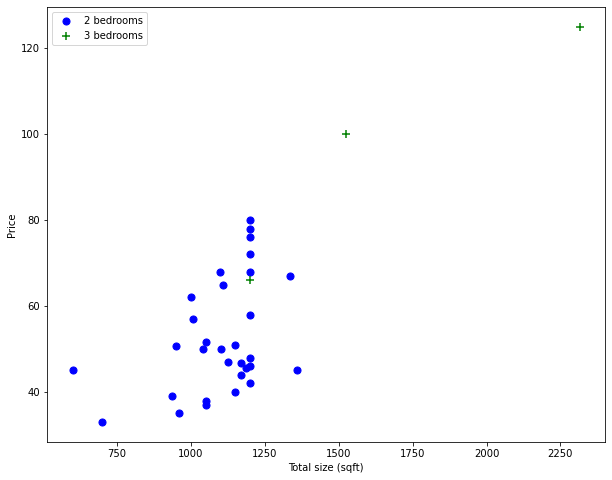

In [28]:
plot_scatter(house_no_outlier, "Ramamurthy Nagar")

In [29]:
house_no_outlier.head()

,location,size,total_sqft,bath,price,price_per_sqrt
1,Devarachikkanahalli,2,1250.0,2.0,40.0,3200.000000
2,Devarachikkanahalli,2,1200.0,2.0,83.0,6916.666667
3,Devarachikkanahalli,2,1170.0,2.0,40.0,3418.803419
4,Devarachikkanahalli,3,1425.0,2.0,65.0,4561.403509
5,Devarachikkanahalli,2,947.0,2.0,43.0,4540.654699


- **We can see that the price_per_sqft columns has almost a normal distribution**

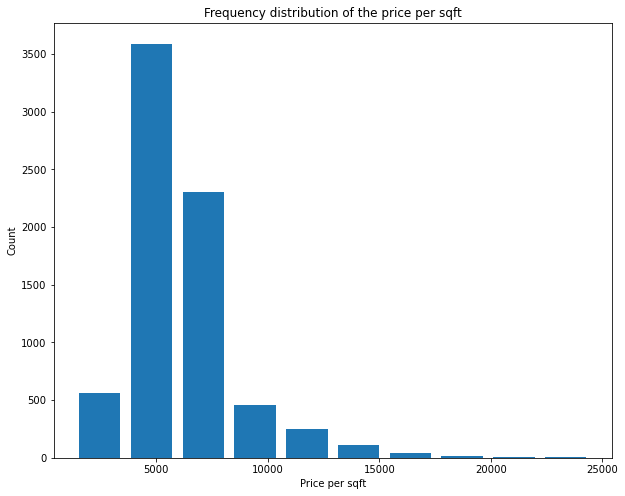

In [30]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.hist(house_no_outlier.price_per_sqrt, rwidth=0.8)

plt.title("Frequency distribution of the price per sqft")
plt.xlabel("Price per sqft")
plt.ylabel("Count")
plt.show()

- **Let's do the same exploration on the bath and size column**

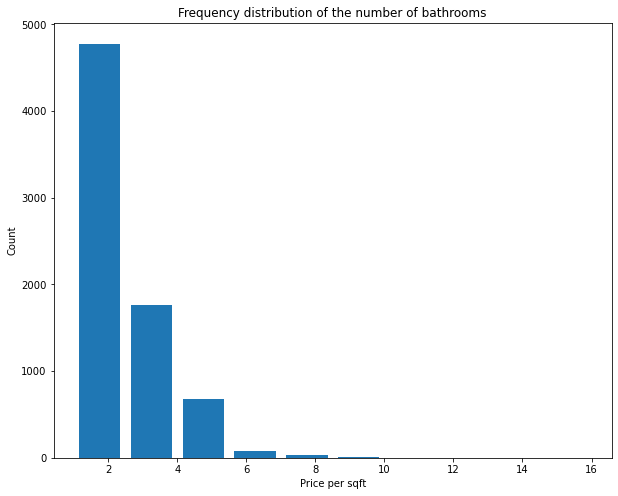

In [31]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.hist(house_no_outlier.bath, rwidth=0.8)

plt.title("Frequency distribution of the number of bathrooms")
plt.xlabel("Price per sqft")
plt.ylabel("Count")
plt.show()

- **The following df shows the cases where the number of baths is higher than the number bedrooms plus 2!** 
- We'd like to remove those rows

In [32]:
house_no_outlier[house_no_outlier["size"]+2 < house_no_outlier.bath]

,location,size,total_sqft,bath,price,price_per_sqrt
1637,Chikkabanavar,4,2460.0,7.0,80.0,3252.032520
5232,Nagasandra,4,7000.0,8.0,450.0,6428.571429
6702,Thanisandra,3,1806.0,6.0,116.0,6423.034330
8405,other,6,11338.0,9.0,1000.0,8819.897689


In [33]:
house_no_outlier = house_no_outlier[house_no_outlier["size"]+2 > house_no_outlier.bath]
house_no_outlier.shape

(7264, 6)

### Building a ML model
- **Now that the data is clean and the outliers are removed; we can build our machine learning model:**

In [34]:
house_final = house_no_outlier.drop("price_per_sqrt", axis = 1)
house_final.head()

,location,size,total_sqft,bath,price
1,Devarachikkanahalli,2,1250.0,2.0,40.0
2,Devarachikkanahalli,2,1200.0,2.0,83.0
3,Devarachikkanahalli,2,1170.0,2.0,40.0
4,Devarachikkanahalli,3,1425.0,2.0,65.0
5,Devarachikkanahalli,2,947.0,2.0,43.0


- **Creating a dummy variable for the location column**

In [35]:
house_final = pd.get_dummies(house_final, prefix = "", prefix_sep = "", drop_first=True)
house_final.head()

,size,total_sqft,bath,price,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,2,1250.0,2.0,40.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1200.0,2.0,83.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1170.0,2.0,40.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1425.0,2.0,65.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,947.0,2.0,43.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Here's the initial x (independent variables ) and y (dependent or target variable) needed for our ML model 

In [38]:
x = house_final.drop("price", axis = 1)
y = house_final["price"]

**Since we're dealing with a regression problem (our target variable gets continues values), we'll try to find the best parameter for the following three models and choose the best one**:
- Linear Regression
- Lasso
- Decision Tree Regressor

The following function does the job:

In [39]:
def best_model_param(X, Y):
    algo = {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {
                "normalize": [True, False]
            }
        }, 
        "Lasso": {
            "model": Lasso(),
            "params": {
                "alpha": np.logspace(-2, 2, 20),
                "selection": ["random", "cyclic"]
            }
        },
        "Decision Tree Regressor": {
            "model": DecisionTreeRegressor(),
            "params": {
                "criterion": ["mse", "friedman_mse"], 
                "splitter": ["best", "random"]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state = 0)
    
    for model_name, config in algo.items():
        
        model_cv = GridSearchCV(config["model"], config["params"], cv = cv, return_train_score=False)
        model_cv.fit(X, Y)
        scores.append({
            "model_name": model_name,
            "best_score": model_cv.best_score_,
            "best_params": model_cv.best_params_
        })
    
    return pd.DataFrame(scores, columns=["model_name", "best_score", "best_params"])

In [40]:
best_model_param(x, y)

,model_name,best_score,best_params
0,Linear Regression,0.845404,{'normalize': False}
1,Lasso,0.845055,"{'alpha': 0.01, 'selection': 'cyclic'}"
2,Decision Tree Regressor,0.746901,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


- **Both Lasso and LinearRegression give 84 % accuracy for this dataset. We choose Linear regression to predict the house price:**

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

- Here's the function that predicts the final price based on the **location**, the **number of bedrooms**, the **total sqft** and the **number of baths**

In [47]:
def predict_price(location, n_bedrooms, total_sqft, bath):
    
    loc_index = np.where(x.columns == location)[0][0]
    
    inp = np.zeros(len(x.columns))
    inp[0] = n_bedrooms
    inp[1] = total_sqft
    inp[2] = bath
    if loc_index >= 0:
        inp[loc_index] = 1
    return reg.predict([inp])[0]
    

- Below are some examples

In [43]:
predict_price("1st Phase JP Nagar", n_bedrooms=2, total_sqft=1000, bath=2)

88.99118105174108

In [44]:
predict_price("1st Phase JP Nagar", n_bedrooms=2, total_sqft=2000, bath=1)

168.8427123146942

- Here I save my model and the columns into pickle and json files, which I will need for later

In [45]:
import pickle
with open("Banglore_home_price_prediction.pickle", "wb") as f:
    pickle.dump(reg, f)

In [46]:
import json
columns = {
    "columns" : [col.lower() for col in x.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

**To be continued..**
- I will later continue to put my results into a Python Flask Server..